

<h1>
<hr style=" border:none; height:3px;">
<center>Lecture 4</center>
<hr style=" border:none; height:3px;">
</h1>

This example is extracted from the following paper :
Vowels MJ. Trying to outrun causality with machine learning: Limitations of model explainability techniques for identifying predictive variables. arXiv preprint arXiv:2202.09875. 2022 Feb 20.

https://arxiv.org/pdf/2202.09875.pdf

Install useful libraries

In [1]:
!pip install dowhy
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-3build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import random
#from scipy import stats
#import time
#from collections import defaultdict
#import warnings
#from scipy.stats import rankdata
#import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import dowhy
from dowhy import CausalModel
import graphviz as gr
import pygraphviz

##Preliminaries for the estimation of effects parts

Import useful librairies

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import shap

Create functions that provide plots of RF importances for a given set of preds and outcome


In [4]:
def get_importances(predictors, outcome, feature_names, standardize=False):
    '''Gets bi-covs, bi_corrs,linear reg coeffs, RF importances, RF shap and MLP/NN shap output.
    :param predictors: array of preds (N, D)
    :param outcome: array of outcome (N, 1)
    :param feature_names: list of var names as strings
    :param standardize: where to standardize the data (does not apply to the computation of
    biv_covs, biv_corrs, or lr_coefs).
    :return as np.arrays (D,) of biv_corrs, biv_covs, rf_imps, rf_shaps, nn_shap, lin_coefs'''
    
    biv_covs = []
    biv_corrs = []
    for i in range(predictors.shape[1]):
        biv_covs.append(np.abs(np.cov(predictors[:, i], outcome,))[0,1])
        biv_corrs.append(np.abs(np.corrcoef(predictors[:, i], outcome,))[0,1])
        
    print('------------LR (always unstandardizd)---------------')
    # compare with linear regression coefficients
    reg = LinearRegression().fit(predictors, outcome)
    X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)
    predictions = reg.predict(X_test)
    lr_coefs =  np.abs(reg.coef_)
    print('MSE', mean_squared_error(predictions, y_test))
    
        
    if standardize:
        predictors = ((predictors - predictors.mean(0)) / (predictors.std(0)))
        X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)

    
    print('------------RF---------------')
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train)
    predictions = forest.predict(X_test)
    rf_importances = forest.feature_importances_

    
    shap_sample_inds_train = np.random.choice(np.arange(0,len(X_train)), 500)
    shap_sample_inds_test = np.random.choice(np.arange(0,len(X_test)), 500)
    explainer = shap.TreeExplainer(forest, X_train[shap_sample_inds_train])
    rf_shap_vals = np.mean(np.abs(explainer.shap_values(X_test[shap_sample_inds_test], approximate=True)),0)
    print('MSE', mean_squared_error(predictions, y_test))
    
    print('------------NN---------------')
    nn_regr = MLPRegressor(hidden_layer_sizes=(100,),
                           activation='relu', solver='adam', alpha=0.0001,
                           batch_size='auto', learning_rate='adaptive',
                           learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,)
    nn_regr.fit(X_train, y_train)
    predictions = nn_regr.predict(X_test)
    
    explainer = shap.KernelExplainer(nn_regr.predict, shap.sample(X_train, 500))
    nn_shap_vals = np.mean(np.abs(explainer.shap_values(X_test, nsamples=500)),0)
    print('MSE', mean_squared_error(predictions, y_test))
    
    

    return np.asarray(biv_covs), np.asarray(biv_corrs), rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs

In [5]:
def plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coef, feature_names, graph_name):
    '''Bar plot with variables and different importance measures.'''
    
    all_results = pd.DataFrame([lr_coef, rf_importances, rf_shap_vals, nn_shap_vals]).T
    all_results.index = feature_names
    cols = ['LR-coefs', 'RF-imps', 'RF-Shap', 'NN-Shap']
    all_results.columns = cols
    min_, max_ = all_results.min(), all_results.max()
    m = (1 - min_) / (max_ - min_)
    b = min_ - m*min_
    all_results = all_results *m + b
    #all_results.clip(lower=0, upper=1, inplace=True)
    all_results['bi-corrs'] = biv_corrs
    all_results['Var Names'] = all_results.index

    ax = plt.figure(figsize=(10, 6)).add_subplot(111)
    all_results.plot(ax=ax, x="Var Names", y=cols.append('bi-corrs'), kind="bar",fontsize=16, alpha=0.7)
    bars = ax.patches
    hatches = ''.join(h*len(all_results) for h in 'x/O.')
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=5,fontsize=12)
    ax.set_ylim(0, 1.15)
    ax.figure.savefig(graph_name, dpi=200)

###**Graphs : why should we care?**

### **Example 1**

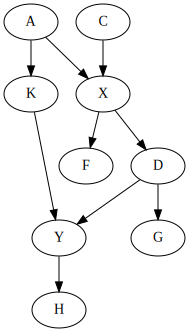

In [6]:
g = gr.Digraph()
g.edge("A", "K"), g.edge("C", "X"), g.edge("A", "X"),g.edge("X","F"), g.edge("X","D"),g.edge("D","G"),g.edge("K","Y"),g.edge("D","Y"),g.edge("Y","H")
g

We associate a SCM to this graph 

In [7]:
N = 200

###############################################################
######## EITHER RUN: ########
low_corr = 0
C = np.random.randn(N,1)   # exogenous cause of X
A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
K = A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
X = C - 2*A + 0.2 * np.random.randn(N,1)  # treatment variable
F = 3*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
D = -2*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
G = D + 0.5 * np.random.randn(N,1)  # descendent of mediator
Y = 2*K - D + 0.2 * np.random.randn(N,1)  # outcome variable 
H = 0.5*Y + 0.1 * np.random.randn(N,1)  # effect of Y

feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']

### Investigate $X\rightarrow Y$ using classical importance measures. Start by looking at the result with ALL variables 

In [8]:
predictors = np.concatenate((C, A, K, X, F, D, G, H),1)
outcome =  Y[:,0]

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='all_preds.png')

biv_covs_a,biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a = get_importances(predictors, outcome, feature_names, standardize=True)

for i, corr in enumerate(biv_corrs_a):
    print(feature_names[i], corr)

------------LR (always unstandardizd)---------------
MSE 0.021877386211722798
------------RF---------------
MSE 0.22144574898168562
------------NN---------------


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.2431214006353189
C 0.7479206628024041
A 0.6525864698874065
K 0.6448805897948244
X 0.9261857440685792
F 0.91318050228946
D 0.9458656250312854
G 0.941191362689768
H 0.9970541461374127


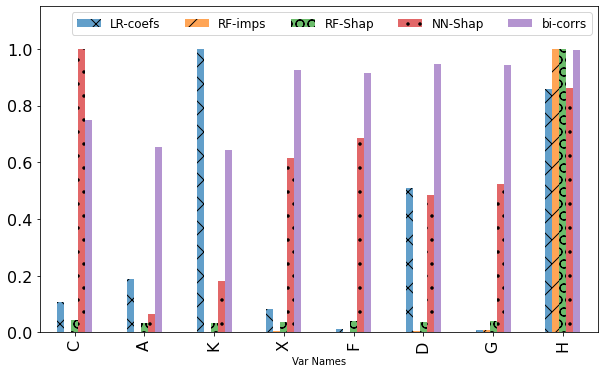

In [9]:
gn = 'all_preds_std.png' if not low_corr else 'all_preds_std_low_corr.png'
plot_results(biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a, feature_names, graph_name=gn)

##Let's remove the effect of Y, which is 'H'


------------LR (always unstandardizd)---------------
MSE 0.04101257261946591
------------RF---------------
MSE 0.5459945034138196
------------NN---------------


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.36041579634460924


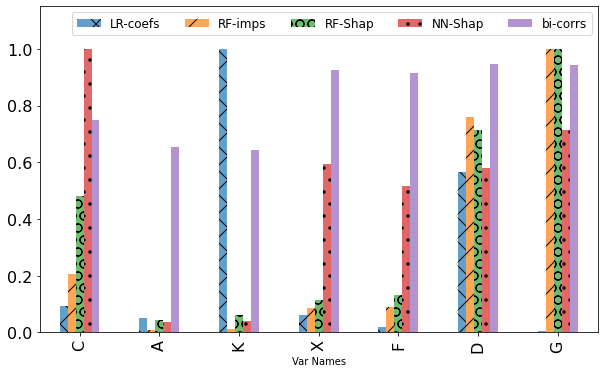

In [10]:
# remove effect of y
predictors = np.concatenate((C, A, K, X, F, D, G),1)
outcome =  Y[:,0]
feature_names_b = ['C', 'A', 'K', 'X', 'F', 'D', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H.png')
gn = 'no_H_std.png' if not low_corr else 'no_H_std_low_corr.png'
biv_covs_b,biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b = get_importances(predictors, outcome, feature_names_b, standardize=True)
plot_results(biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b, feature_names_b, graph_name=gn)

##Now let's remove the mediator 'D'. Surely now we will see 'X' linked with 'Y'?

------------LR (always unstandardizd)---------------
MSE 0.19084019325074464
------------RF---------------
MSE 0.6690862811831518
------------NN---------------


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.41249201922218004


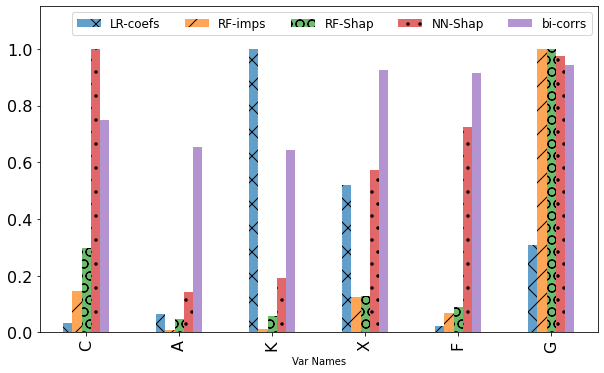

In [11]:
# remove mediator
predictors = np.concatenate((C, A, K, X, F, G),1)
outcome =  Y[:,0]
feature_names_c = ['C', 'A', 'K', 'X', 'F', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H_no_D.png')

biv_covs_c,biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c = get_importances(predictors, outcome, feature_names_c, standardize=True)
gn = 'no_H_no_D_std.png' if not low_corr else 'no_H_no_D_std_low_corr.png'
plot_results(biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c, feature_names_c, graph_name=gn)

### **Example 2**

In [12]:
# #Alternatively, with lower levels of association
low_corr = 1 
C = np.random.randn(N,1)   # exogenous cause of X
A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
K = 0.2*A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
X = 0.2*C - 0.4*A + 0.2 * np.random.randn(N,1)  # treatment variable
F = 0.6*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
D = -0.4*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
G = 0.2*D + 0.5 * np.random.randn(N,1)  # descendent of mediator
Y = 0.4*K - D + 0.2 * np.random.randn(N,1)  # outcome variable 
H = 0.1*Y + 0.1 * np.random.randn(N,1)  # effect of Y
# ###############################################################
feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']

### **Estimation of the causal effect using the library dowhy**

In [13]:
example1_array=np.concatenate((C, A, K, X, F, D, G, Y,H),axis=1)
df = pd.DataFrame(data = example1_array, columns=['C', 'A', 'K', 'X', 'F', 'D', 'G', 'Y','H'])

In [14]:
causal_graph = """digraph {
F;
G;
H;
A->K;
A->X;
C->X;
X->F;
X->D;
K->Y;
D->Y;
D->G;
Y->H;
}"""

In [15]:
model=CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment="X",
        outcome="Y"
        )

In [16]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|K])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,K,U) = P(Y|X,K)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[C]    ⎝d[C]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{C})
Estimand assumption 2, Exclusion: If we remove {C}→{X}, then ¬({C}→Y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([D])⎥
 ⎣d[D]    d[X]     ⎦
Estimand assumption 1, Full-mediation: D intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{D} then P(D|X,U) = P(D|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{D} and U→Y then P(Y|D, X, U) = P(Y|D, X)



In [17]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|K])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,K,U) = P(Y|X,K)

## Realized estimand
b: Y~X+K+X*K
Target units: ate

## Estimate
Mean value: 0.5228093678510216

